In [45]:
import datetime

import torch
import requests

from model import Model
import matplotlib.pyplot as plt
import numpy as np

In [46]:
tmrw = 1 # 0 if today, 1 if tmrw
hourOffset = -24 # can be between -24 and 0

device = (
    # "cuda"
    # if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    # else "cpu"
    "cpu"
)


In [47]:
model = Model()
model.load_state_dict(torch.load('data/model.pt', map_location=torch.device(device)))
model.to(device)

Model(
  (layer1): Linear(in_features=9, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=800, bias=True)
  (layer3): Linear(in_features=800, out_features=1500, bias=True)
  (layer4): Linear(in_features=1500, out_features=3000, bias=True)
  (layer7): Linear(in_features=3000, out_features=1500, bias=True)
  (layer8): Linear(in_features=1500, out_features=800, bias=True)
  (layer9): Linear(in_features=800, out_features=200, bias=True)
  (layer10): Linear(in_features=200, out_features=1, bias=True)
  (Activate): ReLU()
)

In [48]:

today = datetime.datetime.now()
url = ("https://api.open-meteo.com/v1/forecast?latitude=41.6117&longitude=-93.8852&hourly=temperature_2m"
       "&temperature_unit=fahrenheit&timezone=America%2FChicago&start_date=") + str(datetime.datetime.fromtimestamp(
    today.timestamp() - 950400).date()) + "&end_date=" + str(today.date())
response = requests.get(url)
data = response.json()


Single Prediction

In [49]:
actual = []
predicted = []
tmrw = 0 # 0 if today, 1 if tmrw
hourOffset = 0 # can be between -24 and 0

tod = data["hourly"]["temperature_2m"][264 + today.hour + hourOffset]

print("Actual temperature: " + str(tod))
actual.append(tod)

# if tmrw > 0:


inp = torch.FloatTensor([
	today.year,                                         # year
	today.month,                                        # month
	today.day + tmrw,                                   # day
	today.hour,                                         # hour
	(round((today.minute - 15) / 20) * 20 - 5),         # nearest minute model allows
	data["hourly"]["temperature_2m"][216+24 + today.hour + tmrw*24 + hourOffset], # yesterday's temp
	data["hourly"]["temperature_2m"][192+24 + today.hour + tmrw*24 + hourOffset], # ereyesterday's temp
	data["hourly"]["temperature_2m"][120+24 + today.hour + tmrw*24 + hourOffset], # temp 5 days ago
	data["hourly"]["temperature_2m"][24+today.hour + tmrw*24 + hourOffset]        # temp 10 days ago
]).to(device)

print("Predicted temperature: " + str(model(inp)[0].item()))
predicted.append(model(inp)[0].item())

Actual temperature: 64.1
Predicted temperature: 73.95616149902344


Hourly Prediction for next day

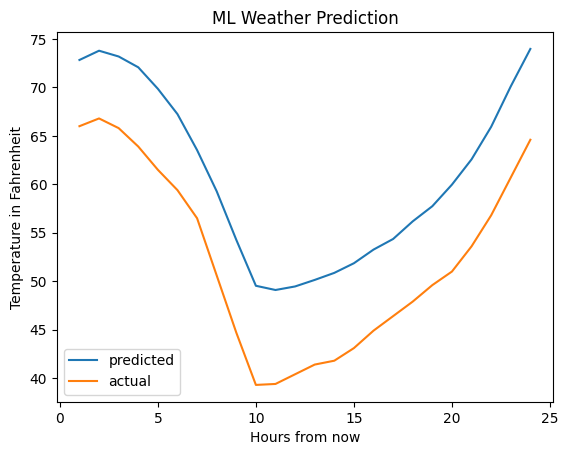

In [51]:
hourOffset = -24
x_values = []
actual = []
predicted = []
tmrw = 1 # 0 if today, 1 if tmrw
hourOffset = -24 # can be between -24 and 0

for i in range(24):
    tod = data["hourly"]["temperature_2m"][264 + today.hour + hourOffset]
    x_values.append(24-i)

    actual.append(tod)

    # if tmrw > 0:


    inp = torch.FloatTensor([
        today.year,                                         # year
        today.month,                                        # month
        today.day + tmrw,                                   # day
        today.hour,                                         # hour
        (round((today.minute - 15) / 20) * 20 - 5),         # nearest minute model allows
        data["hourly"]["temperature_2m"][216+24 + today.hour + tmrw*24 + hourOffset], # yesterday's temp
        data["hourly"]["temperature_2m"][192+24 + today.hour + tmrw*24 + hourOffset], # ereyesterday's temp
        data["hourly"]["temperature_2m"][120+24 + today.hour + tmrw*24 + hourOffset], # temp 5 days ago
        data["hourly"]["temperature_2m"][24+today.hour + tmrw*24 + hourOffset]        # temp 10 days ago
    ]).to(device)

    predicted.append(model(inp)[0].item())
    hourOffset += 1


plt.plot(np.array(x_values), np.array(predicted), label = "predicted")
plt.plot(np.array(x_values), np.array(actual), label = "actual")
plt.xlabel("Hours from now")
plt.ylabel("Temperature in Fahrenheit")
plt.title("ML Weather Prediction")
plt.legend()
plt.show()